In [1]:
import pandas as pd
import dalmatian
import matplotlib.pyplot as plt
import numpy as np
import subprocess
import matplotlib
import copy
import os
import seaborn as sns
import scipy.stats as stats
import pickle
import signatureanalyzer as sa
from statannotations.Annotator import Annotator

import warnings
warnings.filterwarnings("ignore")

from statsmodels.stats.multitest import multipletests

plt.rcParams["figure.figsize"] = (12,7)
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['figure.dpi'] = 150
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['axes.titlesize'] = 20

import sys
sys.path.append('../utility_code/')
import general_utils as utils

import warnings
warnings.filterwarnings('ignore')

In [2]:
'''
loading nmf results
'''

res_supervised = pd.read_pickle('../data/supervised_nmf_results.ob')

W = res_supervised['W']
H = res_supervised['H']


'''
loading maf file
'''

maf_file = '../data/final_pairs.aggregated.tsv'
maf = pd.read_csv(maf_file, sep='\t')
maf['Tumor_Sample_Barcode'] = maf['sample']

sa_maf, spectra = sa.spectra.get_spectra_from_maf(maf, hgfile='hg19.2bit', reference='cosmic3')
W.index = sa.plotting._muts._map_sbs_sigs_back(W)
df_maf = sa.utils.assign_signature_weights_to_maf(sa_maf, W, H)


'''
loading annotation file and merging
'''


df_annot = pd.read_csv('../data/sample_annotations.tsv', sep='\t')

df_maf = df_maf[df_maf['Variant_Classification'].isin(["Missense_Mutation","Nonsense_Mutation","Splice_Site",
                                                            "Nonstop_Mutation","Frame_Shift_Ins","Frame_Shift_Del", 
                                                            "De_novo_Start_InFrame","Start_Codon_SNP", "In_Frame_Del",
                                                            "In_Frame_Ins","De_novo_Start_OutOfFrame","Start_Codon_Del",
                                                            "Stop_Codon_Del"])]

df_maf = df_maf[df_maf['ccf_hat']>.75]

df_maf['SBS2_13'] = df_maf['SBS2'] + df_maf['SBS13']

sigs = ['SBS1', 'SBS4', 'SBS5', 'SBS2_13']

In [3]:
'''
counting tmbs
'''
samp_tmbs = {}
for samp in df_maf['sample'].unique():
    samp_tmbs[samp] = sum(df_maf[(df_maf['sample']==samp)&(df_maf['ccf_hat']>.75)]['SBS2_13']) / 30

'''
merging tmb and annotation dataframe
'''
df_tmb = pd.DataFrame.from_dict(samp_tmbs, orient='index')
df_tmb['tmb_clonal'] = df_tmb[0]
df_tmb.drop(columns=[0], inplace=True)
df_tmb['sample'] = df_tmb.index
df = pd.merge(df_tmb, df_annot, on='sample', how='left')
df.set_index('analysis_id', inplace=True)


'''
groups for boxplot:
cfDNA_earliest, cfDNA_latest, baseline_tissue, baseline_tissue_w_prior_io, baseline_tissue_wo_prior_io
'''
groups = []
for part in df['participant'].unique():
    df_sub = df[df['participant']==part]
    
    if df_sub['indicator'].isin(['S']).any():
        samp = df_sub.reset_index().set_index('indicator').loc['S']['analysis_id']
        df.loc[samp, 'sample_group'] = 'cfDNA_earliest'
        
    elif df_sub['indicator'].isin(['C1D1']).any():
        samp = df_sub.reset_index().set_index('indicator').loc['C1D1']['analysis_id']
        df.loc[samp, 'sample_group'] = 'cfDNA_earliest'
        
        
    if df_sub['indicator'].isin(['EOT']).any():
        samp = df_sub.reset_index().set_index('indicator').loc['EOT']['analysis_id']
        df.loc[samp, 'sample_group'] = 'cfDNA_latest'

    tissue_samp = None
    
    df_tiss = df_sub[df_sub['pdb_original_material_type']=='tissue']
    
    if len(df_tiss) == 1:
        tissue_samp = df_tiss.index.item()
    elif len(df_tiss) > 1: #multiple tissue samples
        if part in ['MCC024']:
            tissue_samp = df_tiss.reset_index().set_index('indicator').loc['prim']['analysis_id']
        elif part == 'MCC008':
            tissue_samp = 'M008-NR-prim'
        else:
            df_tiss = df_tiss[~df_tiss['indicator'].isin(['post_tiss', 'post_tiss-1', 'post_tiss-2'])]
            tissue_samp = df_tiss[df_tiss['collection_date_dfd']==max(df_tiss['collection_date_dfd'])].index.item()
            
    if tissue_samp is not None:
        df_concat = None
        
        df.loc[tissue_samp, 'sample_group'] = 'baseline_tissue'
        
        if df_sub.loc[tissue_samp]['prior_therapy'] == 'Prior IO':
            df_concat = df[df.index==tissue_samp]
            df_concat.loc[tissue_samp, 'sample_group'] = 'tissue_w_prior_io'
            
        elif df_sub.loc[tissue_samp]['prior_therapy'] == 'No Prior IO':
            df_concat = df[df.index==tissue_samp]
            df_concat.loc[tissue_samp, 'sample_group'] = 'tissue_wo_prior_io'
            
        if df_concat is not None:
            df = pd.concat([df, df_concat])

In [4]:
'''
comparing earliest cfDNA to baseline tissue samples
'''

# loading tumor purity
df_p = pd.read_csv('../data/pair_data-table.tsv', sep='\t')
df_p = df_p.set_index('entity:pair_id')
df_p.index.name='pair_id'

purities = []
bloods = []
tissues = []
for part in df[df['sample_group'].isin(['cfDNA_earliest'])]['participant'].unique():
    df_sub = df[df['participant']==part]
    
    if 'S' not in list(df_sub['indicator']):
        continue
        
    if 'baseline_tissue' in list(df_sub['sample_group']):
        pair = df_sub[df_sub['sample_group']=='cfDNA_earliest']['sample'] + '_pair'
        purity = df_p.loc[pair]['absolute_called_purity'].item()
        if purity >= 0:
            df_sub = df_sub.reset_index().set_index('sample_group')

            bloods.append(df_sub.loc['cfDNA_earliest']['tmb_clonal'])
            tissues.append(df_sub.loc['baseline_tissue']['tmb_clonal'])

            pair = df_sub.loc['cfDNA_earliest']['sample'] + '_pair'
            
            purities.append(purity)
            
            
t = copy.deepcopy(tissues)
b = copy.deepcopy(bloods)
        
coef, p = stats.spearmanr(t, b)

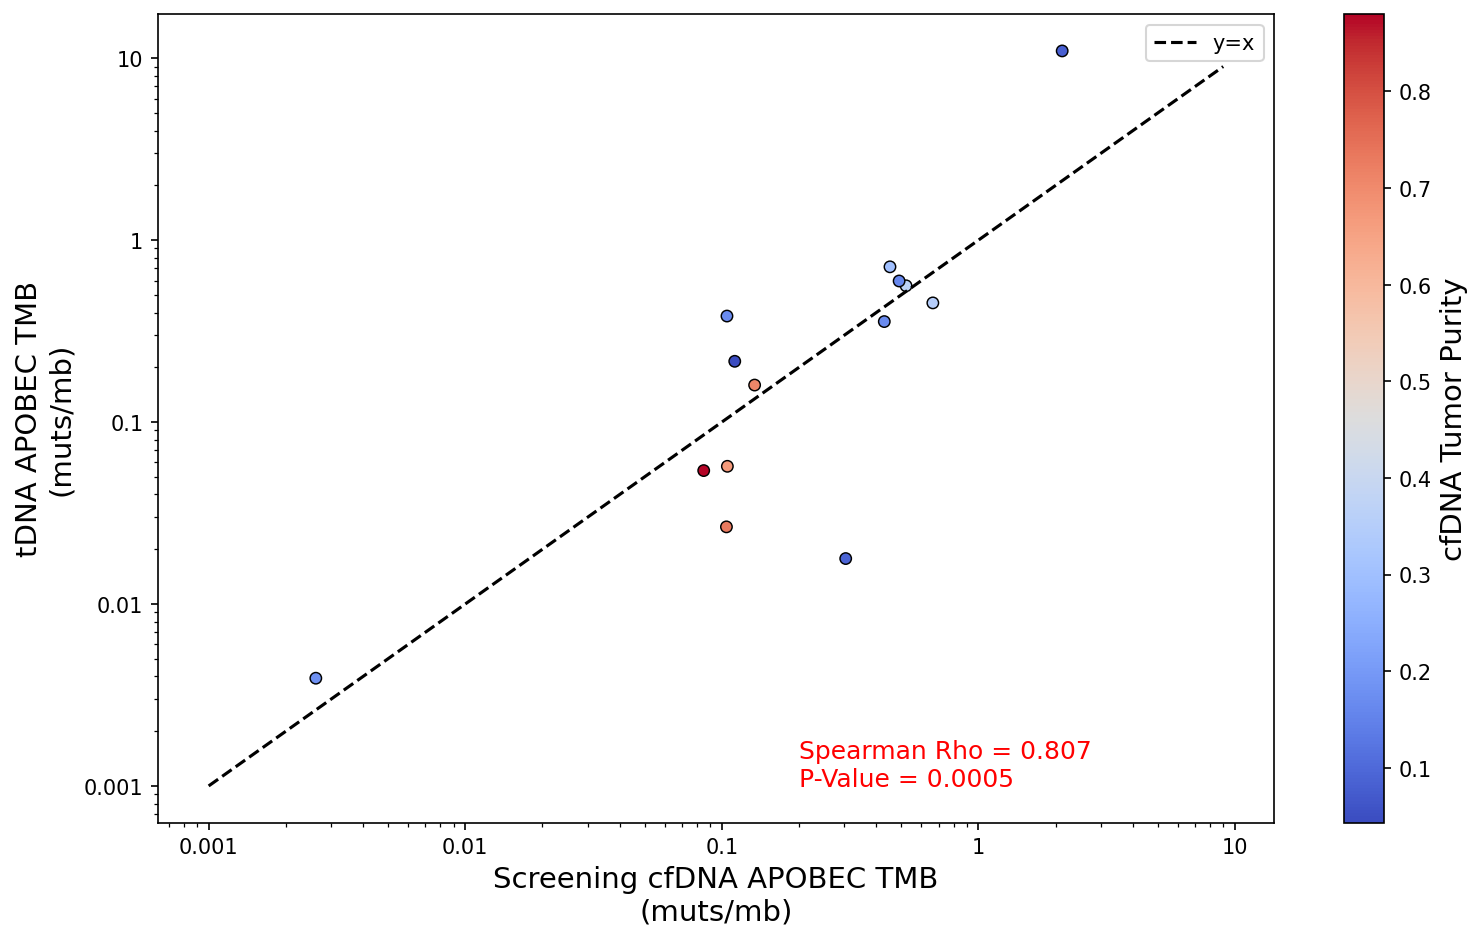

In [5]:
plt.plot(np.linspace(.001, 9), np.linspace(.001, 9), ls='--', c='black')
plt.legend(['y=x'])
plt.scatter(bloods, tissues, c=purities, cmap='coolwarm', s=30, edgecolors='black', linewidths=.7)
cb = plt.colorbar()
cb.set_label('cfDNA Tumor Purity', size=14)
plt.xscale('log')
plt.yscale('log')

xticks = [0.001, .01, .1, 1, 10]
size = 20
plt.xticks(xticks, xticks)
plt.yticks(xticks, xticks)

# plt.autoscale()

plt.annotate(f'Spearman Rho = {round(coef, 3)}\nP-Value = {round(p, 4)}', (.2, .001), size=12, color='red')
plt.xlabel('Screening cfDNA APOBEC TMB\n(muts/mb)', size=14)
plt.ylabel('tDNA APOBEC TMB\n(muts/mb)', size=14);